# Sun - GOLF/SoHO

Using radial velocity observations from the GOLF instrument onboard the SoHO spacecraft with p-mode frequencies determined by Salabert et al. (2015).

In [1]:
import numpy as np
import asterion as ast
from asterion import GlitchModel, Inference
import matplotlib.pyplot as plt

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
# Plotting style setup
plt.style.use('seaborn-darkgrid')
plt.rcParams['legend.frameon'] = True
plt.rcParams['font.size'] = 12.0
plt.rcParams['figure.figsize'] = [8.0, 6.0]

In [3]:
nu_max = (3090., 5.)  # in microhertz
delta_nu = (135.2, 0.5)   # in microhertz
teff = (4777., 10.)    # in Kelvin

In [4]:
from astroquery.vizier import Vizier

In [5]:
v = Vizier(row_limit=-1)
tables = v.query_constraints("J/A+A/578/A137/tables", l="0")

In [6]:
tables

TableList with 1 tables:
	'0:J/A+A/578/A137/tables' with 5 column(s) and 1208 row(s) 

In [7]:
df = tables[0].to_pandas()
df.head()

,Index,n,l,nu,e_nu
0,01,10,0,1548.414,0.041
1,01,11,0,1686.538,0.043
2,01,12,0,1822.197,0.043
3,01,13,0,1957.469,0.051
4,01,14,0,2093.510,0.038


In [8]:
df["epoch"] = df["Index"].astype(int)

Let's choose an epoch to model.

In [9]:
mask = df["epoch"] == 2
n = df.loc[mask, "n"].to_numpy()
nu, nu_err = df.loc[mask, ["nu", "e_nu"]].to_numpy().T

In [10]:
model = GlitchModel(nu_max, delta_nu, teff=teff)

INFO[2022-04-01 15:05:38,211]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-04-01 15:05:38,212]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-04-01 15:05:38,212]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [11]:
infer = Inference(model, n=n, nu=nu, nu_err=nu_err, seed=10)
infer.prior_predictive()  # <-- check prior is sensible
prior_data = infer.get_data()

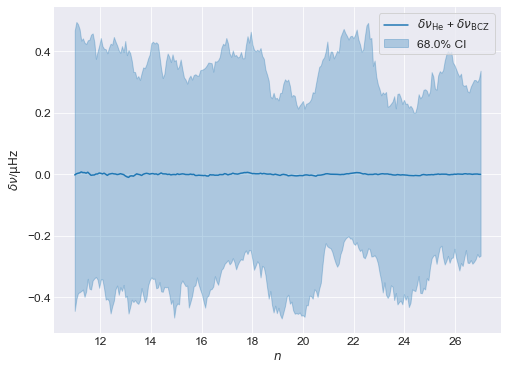

In [12]:
ast.plot_glitch(prior_data, group='prior');

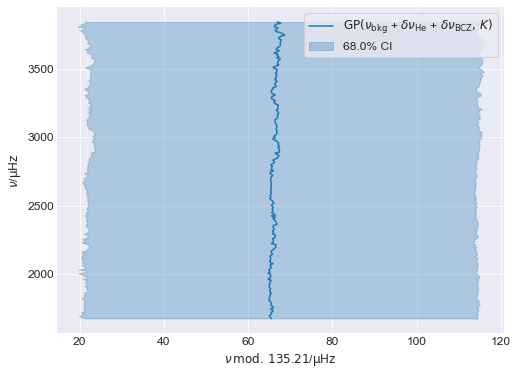

In [13]:
ast.plot_echelle(prior_data, group='prior');

In [14]:
infer.sample()
infer.posterior_predictive()

Running nested sampling using the 'multi_ellipsoid' sampler with 50 live points and 50000 maximum samples...
Completed in 14.4 seconds.


In [15]:
data = infer.get_data()

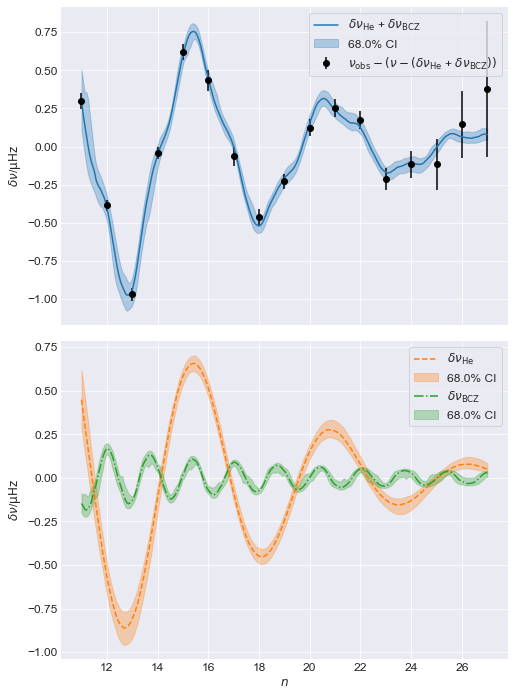

In [16]:
quantiles = [.16, .84]  # <-- 68% confidence interval

_, axes = plt.subplots(2, figsize=(8.0, 12.0), sharex=True, gridspec_kw={"hspace": 0.05})

# FULL GLITCH
ax = axes[0]
ax = ast.plot_glitch(data, quantiles=quantiles, ax=ax)
ax.set_xlabel("")  # Remove xlabel

# GLITCH COMPONANTS
ax = axes[1]
ax = ast.plot_glitch(data, kind='He', quantiles=quantiles, observed=False, ax=ax, color="C1", linestyle="--")
ax = ast.plot_glitch(data, kind='CZ', quantiles=quantiles, observed=False, ax=ax, color="C2", linestyle="-.")

Similarly, we can plot the model on an echelle plot, which folds the mode frequencies on the large frequency separation. By default, it uses the median $\Delta\nu$ from the model, but you can pass `delta_nu` as a keyword argument. Here, the echelle plot does not look right because the model's $\Delta\nu$ is sensitive to the GP. This does not matter because the plot is just a visualisation of the model and its performance.

Text(0, 0.5, '')

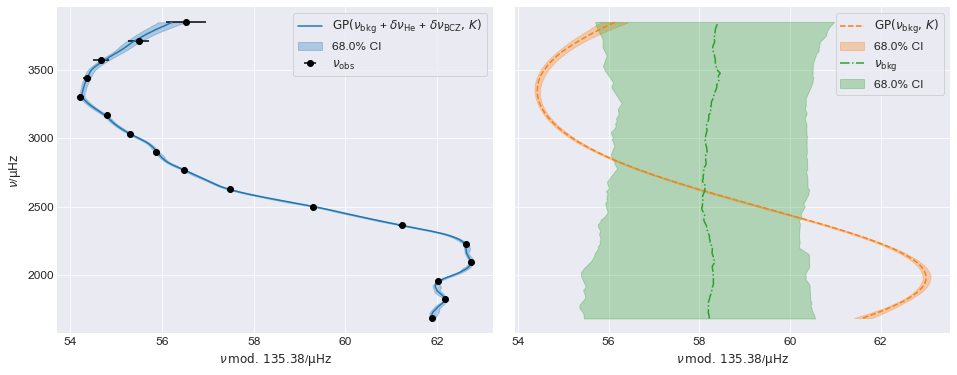

In [17]:
_, axes = plt.subplots(ncols=2, figsize=(16.0, 6.0), sharey=True, gridspec_kw={"wspace": 0.05})

# FULL GLITCH
ax = axes[0]
ax = ast.plot_echelle(data, quantiles=quantiles, ax=ax)

# GLITCH COMPONANTS
ax = axes[1]
ax = ast.plot_echelle(data, kind='glitchless', quantiles=quantiles, observed=False, ax=ax, color="C1", linestyle="--")
ax = ast.plot_echelle(data, kind='background', quantiles=quantiles, observed=False, ax=ax, color="C2", linestyle="-.")
ax.set_ylabel("")  # Remove ylabel

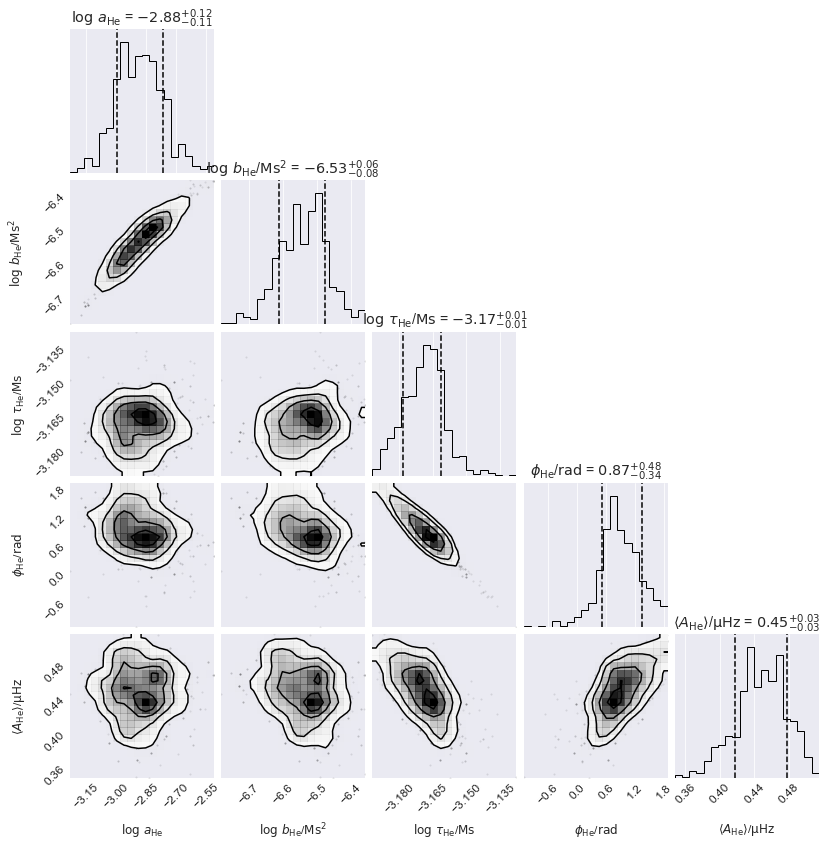

In [18]:
ast.plot_corner(data, var_names=['log_a_he', 'log_b_he', 'log_tau_he', 'phi_he', 'he_amplitude']);

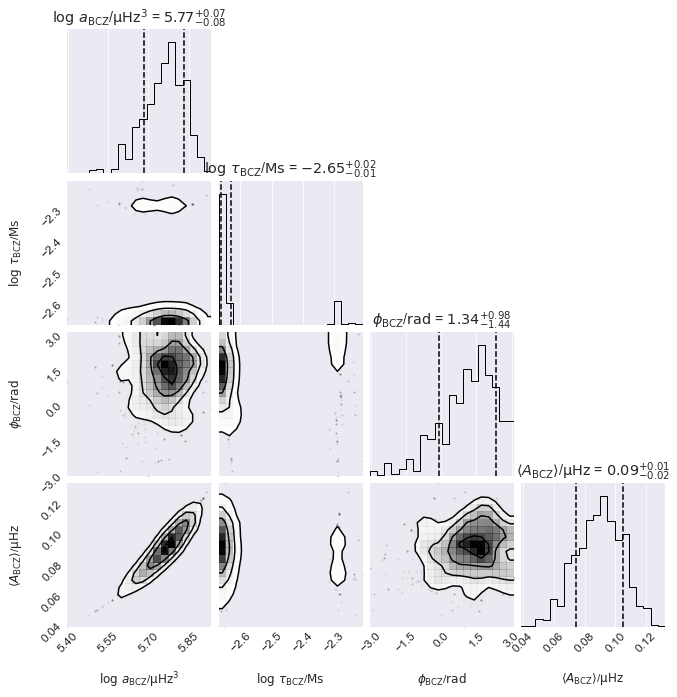

In [19]:
ast.plot_corner(data, var_names=['log_a_cz', 'log_tau_cz', 'phi_cz', 'cz_amplitude']);

Be careful when interpretting $\Delta\nu$ and $\epsilon$. These parameters are specific to this model and may be sensitive to the radial orders observed.

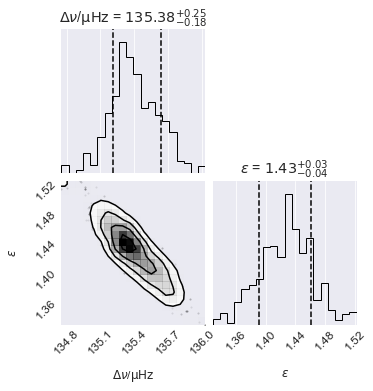

In [20]:
ast.plot_corner(data, var_names=['delta_nu', 'epsilon']);

In [21]:
import astropy.units as u

In [22]:
# Convert to physical quantity from Houdek and Gough (2007)
data.posterior["delta_he"] = np.sqrt(data.posterior["b_he"]/2)/2/np.pi
data.posterior["delta_he"].attrs["unit"] = str(u.megasecond)

In [23]:
from astropy.table import QTable

table = ast.get_table(data, dims=(), var_names=["a_he", "b_he", "tau_he", "a_cz", "tau_cz", "delta_he"], fmt="astropy")
table = QTable(table)  # <-- convert to quantity table
table

metric,a_he,b_he,tau_he,a_cz,tau_cz,delta_he
,,Ms2,Ms,uHz3,Ms,Ms
str4,float64,float64,float64,float64,float64,float64
mean,0.00137,2.92e-07,0.0006778,579600.0,0.00268,6.06e-05
sd,0.00038,4.7e-08,1.41e-05,97000.0,0.0011,4.9e-06
16th,0.00102,2.44e-07,0.0006636,483500.0,0.00217,5.56e-05
50th,0.00131,2.92e-07,0.0006783,584700.0,0.00222,6.08e-05
84th,0.00171,3.34e-07,0.0006901,680300.0,0.00234,6.51e-05


In [24]:
mean = table[table["metric"] == "mean"][0]
sd = table[table["metric"] == "sd"][0]

p16 = table[table["metric"] == "16th"][0]
p50 = table[table["metric"] == "50th"][0]
p84 = table[table["metric"] == "84th"][0]

Approx acoustic depth of the helium-II ionization zone

In [25]:
dp = 1
col = "tau_he"
unit = u.s  # <-- convert to seconds
med = p50[col].to(unit)
em = med - p16[col].to(unit)
ep = p84[col].to(unit) - med
print(f"{col} = {med:.{dp}f} (- {em:.{dp}f}) (+ {ep:.{dp}f})")

tau_he = 678.3 s (- 14.7 s) (+ 11.8 s)


Approx acoustic width of the helium-II ionization zone

In [26]:
dp = 2
col = "delta_he"
unit = u.s
med = p50[col].to(unit)
em = med - p16[col].to(unit)
ep = p84[col].to(unit) - med
print(f"{col} = {med:.{dp}f} (- {em:.{dp}f}) (+ {ep:.{dp}f})")

delta_he = 60.80 s (- 5.20 s) (+ 4.30 s)


Acoustic depth of the base of the convective zone

In [27]:
dp = 0
col = "tau_cz"
unit = u.s
med = p50[col].to(unit)
em = med - p16[col].to(unit)
ep = p84[col].to(unit) - med
print(f"{col} = {med:.{dp}f} (- {em:.{dp}f}) (+ {ep:.{dp}f})")

tau_cz = 2220 s (- 50 s) (+ 120 s)
